# Project Demo Notebook

This notebook demonstrates the main features of the project, including data loading, regime detection, risk analysis, Monte Carlo simulation, and visualization.


In [1]:
# Imports
import sys
import os
sys.path.append('src')  # Ensure src/ is in the path
import pandas as pd
import numpy as np
from data import DataLoader, PortfolioConfig
from regime import MarketRegimeDetector, RegimeConfig
from risk import RiskManager, RiskConfig
from monte_carlo import MonteCarlo, SimConfig
from visualization import PortfolioVisualizer


In [2]:
# 1. Set up your portfolio config and load data
tickers = ['AAPL']
config = PortfolioConfig(
    tickers=tickers,
    start_date='2023-01-01',
    end_date='2023-12-31',
    weights=[1.0],
    ohlcv=False,
    normalize=True,
    frequency='D',
    use_cache=False
)
loader = DataLoader(config)
market_data = loader.load_data()
prices = market_data['prices']
returns = market_data['returns']
print("prices shape:", prices.shape)
print("prices columns:", prices.columns)
print(prices.head())
print("returns shape:", returns.shape)
print("returns columns:", returns.columns)
print(returns.head())
# 3. Only proceed if returns has data
if isinstance(returns, pd.DataFrame) and returns.shape[1] > 0 and returns.shape[0] > 0:
    asset_returns = returns.iloc[:, 0]
    print(f"Using asset: {returns.columns[0]}")
    regime_config = RegimeConfig()
    regime_detector = MarketRegimeDetector(regime_config)
    regimes = regime_detector.fit_predict(asset_returns)
    print(regimes.value_counts())
else:
    print("No valid return data available for regime detection. Please check your tickers and date range.")

2025-07-18 16:05:45,027 - data - INFO - Loading market data...
/Users/lucas/researchlucas/src/data.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ticker_data = yf.download(
2025-07-18 16:05:45,963 - data - INFO - Successfully loaded data for 1 tickers
2025-07-18 16:05:45,978 - regime - INFO - Initialized MarketRegimeDetector with 3 regimes


Ticker: AAPL, Data shape: (250, 5), Columns: Index(['Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL'], dtype='object')
            Close AAPL   High AAPL    Low AAPL   Open AAPL  Volume AAPL
Date                                                                   
2023-01-03  123.470612  129.226052  122.582119  128.613985    112117500
2023-01-04  124.744110  127.014701  123.480480  125.267331     89113600
2023-01-05  123.421257  126.136090  123.164587  125.504275     80962700
2023-01-06  127.962425  128.623856  123.292916  124.398597     87754700
2023-01-09  128.485672  131.703994  128.229002  128.801587     70790800
prices shape: (250, 1)
prices columns: Index(['AAPL'], dtype='object')
                  AAPL
Date                  
2023-01-03  123.470612
2023-01-04  124.744110
2023-01-05  123.421257
2023-01-06  127.962425
2023-01-09  128.485672
returns shape: (249, 1)
returns columns: Index(['AAPL'], dtype='object')
                AAPL
Date                
2023-01-04  0

In [3]:
regime_config = RegimeConfig()
regime_detector = MarketRegimeDetector(regime_config)

# Use the first asset's returns for regime detection, with robust checks
if isinstance(returns, pd.DataFrame):
    if returns.shape[1] == 0:
        raise ValueError("The returns DataFrame has no columns.")
    asset_returns = returns.iloc[:, 0]
else:
    asset_returns = returns

regimes = regime_detector.fit_predict(asset_returns)
print(regimes.value_counts())

2025-07-18 16:05:49,337 - regime - INFO - Initialized MarketRegimeDetector with 3 regimes


2    103
0     84
1     62
dtype: int64


In [4]:
risk_config = RiskConfig()
risk_manager = RiskManager(risk_config)
risk_metrics = risk_manager.calculate_metrics(returns)
# Show a few key metrics
{k: risk_metrics[k] for k in ['portfolio_volatility', 'var_95', 'max_drawdown', 'sharpe_ratio']}


2025-07-18 16:05:51,982 - regime - INFO - Initialized MarketRegimeDetector with 3 regimes


{'portfolio_volatility': 0.1995433169414594,
 'var_95': -0.01717646366129468,
 'max_drawdown': -0.1493235111443778,
 'sharpe_ratio': 2.066728047986683}

In [5]:
sim_config = SimConfig(n_sims=1000, n_days=252)
mc = MonteCarlo(sim_config)
mc_results = mc.simulate(market_data)
# Show summary statistics
mc_results['statistics']



Running Monte Carlo simulation...


{'mean': 1.556504765748919,
 'median': 1.5565796313907028,
 'std': 0.003690352617878041,
 'skew': -0.12280978790725526,
 'kurtosis': -0.1443448057585588,
 'sharpe_ratio': 408.22786376852025,
 'bias': -8.881784197001253e-17,
 'variance': 4.859246382752883e-09,
 'cross_val_score': 4.4785147125146436e-05}

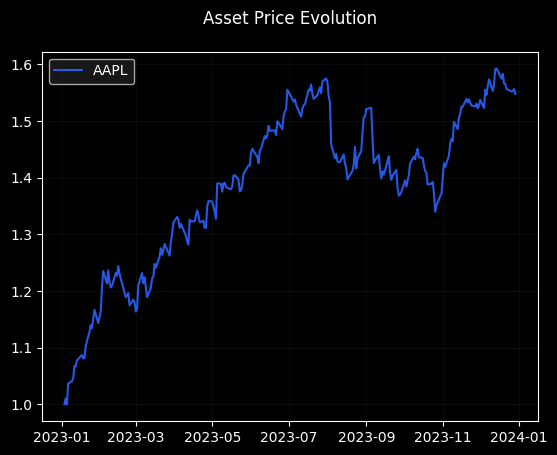

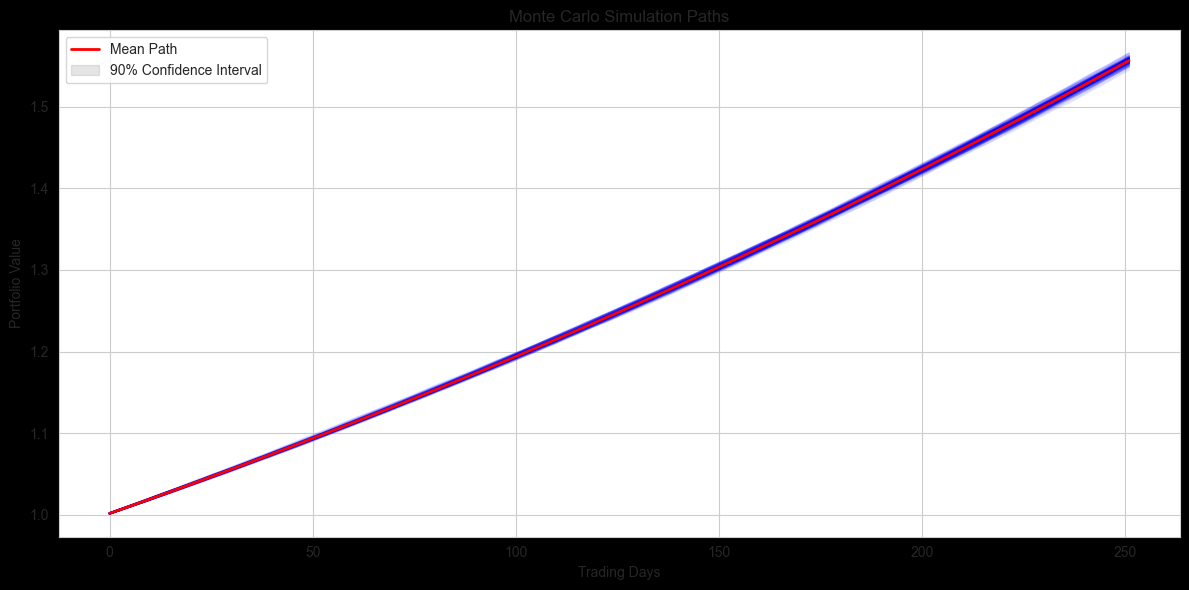

In [7]:
import matplotlib.pyplot as plt
visualizer = PortfolioVisualizer()
# Plot price evolution with detected regimes
visualizer._plot_price_evolution(prices, plt.gca(), regimes=regimes)
plt.show()
# Plot Monte Carlo simulation paths
mc.plot_simulation_paths(mc_results)
